In [11]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import wcs
from ROHSApy import ROHSA
from astropy.wcs import WCS
from matplotlib.path import Path
from skimage.draw import polygon2mask
from skimage.draw import polygon


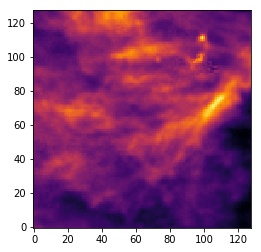

In [22]:
fitsname = "GHIGLS_NCPL_Tb.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
#CRPIX1 is the x axis (RA), CRPIX2 is the y axis (DEC)
hdr['CRPIX1'] -= 189
hdr['CRPIX2'] -= 238
hdr['CRPIX3'] -= 225

#cube = hdu[0].data[0][300:420,218:345, 189:316]
cube = hdu[0].data[0][225:360,238:366, 189:317]

#rms = hdu[2].data[50:82, 80:112]
#mask = hdu[1].data
#LVC IS LOCATED AT 
#cube = hdu[0].data[0][300:350, :, :]
#IVC IS LOCATED AT 
#cube = hdu[0].data[0][360:420, :, :]

#The data from the cube was plotted

plt.imshow(np.sum(cube[:, :, :],0), origin="lower", cmap="inferno")
plt.show()


def wcs2D(hdr):
    w = wcs.WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]
    return w
w = wcs2D(hdr)


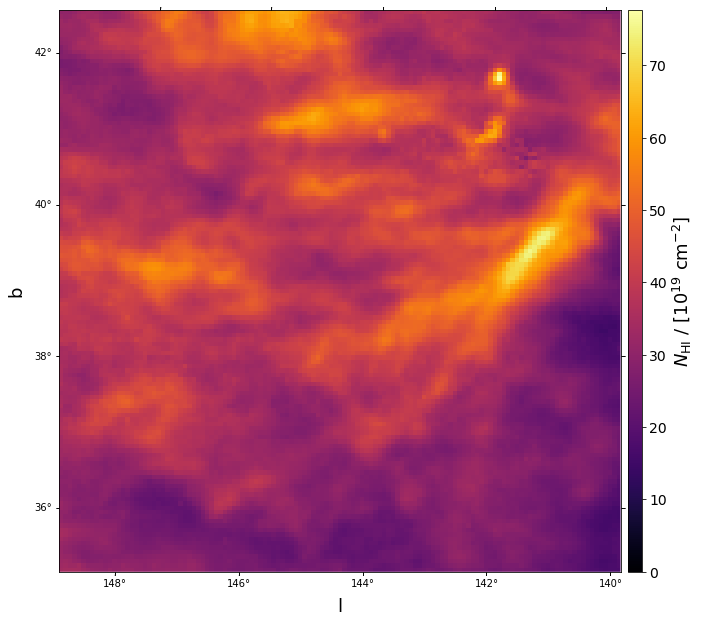

In [13]:
dv = np.abs(hdr['CDELT3'])/1000
NHI = 1.823e18*dv*np.sum(cube, 0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=w)
ax.set_xlabel(r"l", fontsize=18.)
ax.set_ylabel(r"b", fontsize=18.)
cm_inf = plt.get_cmap('inferno')
cm_inf.set_bad(color='white')
cm_inf.set_under(color='black')
imkw_inf = dict(origin='lower', interpolation='none', cmap=cm_inf)
img = ax.imshow(NHI*1.e-19, vmin=0., **imkw_inf)
colorbar_ax = fig.add_axes([0.89, 0.11, 0.02, 0.78])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"$N_{\rm HI}$ / [10$^{19}$ cm$^{-2}$]", fontsize=18.)
#plt.savefig('NHI.png', format='png', bbox_inches='tight', pad_inches=0.02)
plt.show()

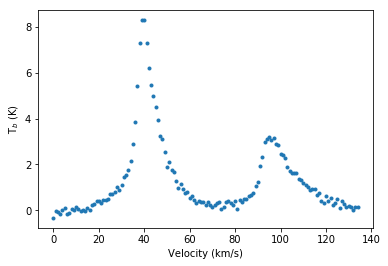

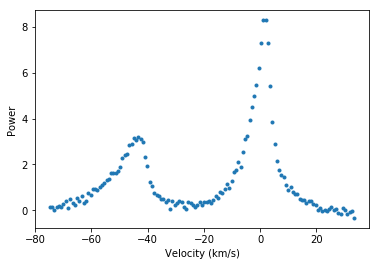

In [14]:
#here I got the ranges for teh LVC and IVC for the new cube
#LVC is from 225-300
#IVC is from 300-360

CRVAL = hdr['CRVAL3']
CDELT = hdr['CDELT3']
CRPIX = hdr['CRPIX3']

ind_array = np.arange(cube.shape[0])

v = (CRVAL + CDELT*((ind_array) - CRPIX))/1000

plt.plot(cube[:,15,15], linestyle = "none", marker = '.')
plt.xlabel("Velocity (km/s)")
plt.ylabel("T$_{b}$ (K)")
plt.show()

plt.plot(v, cube[:,15,15], linestyle = "none", marker = '.')
plt.xlabel("Velocity (km/s)")
plt.ylabel("Power")
plt.show()

In [20]:
#here, we define the vertices of the polygon we will be using for the mask in wcs
polygon_wcs = [(140.87902, 40.399586), (141.5816, 41.974586), (141.89545, 41.974586), (142.28957, 41.916253), (143.23855, 41.3912530), (144.0951, 40.866253), (143.48741, 40.282919),( 140.87902, 40.399586) ]

#these are just the components of the polygon broken up into their l and b components
l = [140.87902, 141.5816, 141.89545,142.28957,143.23855 ,144.0951, 143.48741,  140.87902 ]
b = [ 40.399586, 41.974586, 41.974586, 41.916253, 41.3912530, 40.866253, 40.282919, 40.399586 ]

#this converts the coordinates from wcs to pixels using the adjusted header
x,y = w.wcs_world2pix(l,b, 0)
print(x,y)

#i had to invert the x,y coordinates when stacking in order to properly orient the mask
polygon_pix = np.dstack((y, x))
print(polygon_pix)

[112.1025865  103.21727643  99.21734849  94.17535772  81.80030687
  70.42919433  77.98604063 112.1025865 ] [ 89.3934911  116.39349099 116.39349099 115.3934967  106.39349674
  97.39349678  87.39348539  89.3934911 ]
[[[ 89.3934911  112.1025865 ]
  [116.39349099 103.21727643]
  [116.39349099  99.21734849]
  [115.3934967   94.17535772]
  [106.39349674  81.80030687]
  [ 97.39349678  70.42919433]
  [ 87.39348539  77.98604063]
  [ 89.3934911  112.1025865 ]]]


(128, 128)
(128, 128)


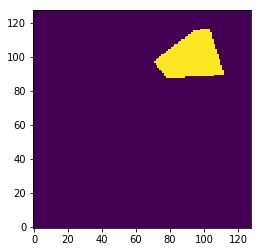

In [23]:
#here we use the polygon2mask function from scikit to create a mask using the polygon we defined above

image_shape = (128, 128)
mask = polygon2mask(image_shape, polygon_pix)

plt.imshow(mask, origin = 'lower')
#plt.savefig('UMA_polygonmask.png')
print(np.shape(mask))
print(np.shape(np.sum(cube, 0)))

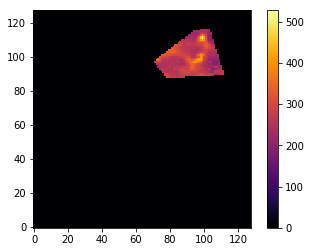

In [27]:
#this is a cube of nothing but the region that we are masking off

masked_cube_inverse = np.copy(cube)
for i in range(cube.shape[0]):
    masked_cube_inverse[i] = masked_cube_inverse[i]*mask

plt.imshow(np.sum(masked_cube_inverse, 0), origin = 'lower', cmap = 'inferno')
plt.colorbar()
plt.savefig('UMA_NCPL_masked_cube_inverse.png')

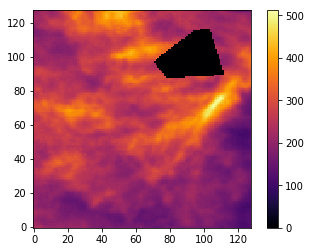

In [28]:
#now we can actually generate our final masked cube, which is masked on each channel

new_mask = np.where(mask == 0, 1,0)
masked_cube = np.copy(cube)

for i in range(cube.shape[0]):
    masked_cube[i] = masked_cube[i]*new_mask

plt.imshow(np.sum(masked_cube, 0), origin = 'lower', cmap = 'inferno')
plt.colorbar()
plt.savefig('UMA_NCPL_masked_cube.png')

In [ ]:
#now finally we can attempt to use the gaussian inpainting package in scikit to fill in the zeroes so that ROHSA can run properly


